## 1.Import thư viện và đọc dữ liệu

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [122]:
df = pd.read_csv('events_processed.csv')
df.head()

C:\Users\quoch\AppData\Local\Temp\ipykernel_17032\1992054768.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('events_processed.csv')


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,year,month,day,quarter,week,weekday,dayofyear,category,sub_category,sub_sub_category,sub_sub_sub_category
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,unknown,31.90,1515915625519388267,LJuJVLEjPT,2020,9,24,3,39,3,268,electronics,telephone,0,0
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,2020,9,24,3,39,3,268,computers,components,cooler,0
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,unknown,unknown,9.81,1515915625513238515,4TMArHtXQy,2020,9,24,3,39,3,268,unknown,0,0,0
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,2020,9,24,3,39,3,268,computers,peripherals,printer,0
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,unknown,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ,2020,9,24,3,39,3,268,unknown,0,0,0


In [123]:
df['event_type'].value_counts()

event_type
view        793589
cart         54029
purchase     37346
Name: count, dtype: int64

## 2. Tỷ lệ từ bỏ giỏ hàng

#### 2.1 Các session có sự kiện là 'cart' và 'purchase'

In [124]:
sessions_with_cart = df[df['event_type'] == 'cart']['user_session'].unique()
sessions_with_purchase = df[df['event_type'] == 'purchase']['user_session'].unique()

print(sessions_with_cart[:5])
print(sessions_with_purchase[:5])


['UzabYgCPva' '0KdrxeTB4x' '2gngxS29Ts' '3jFpdbozOd' 'U0jPRvGG9t']
['xn6SHCnZtk' '2gngxS29Ts' '3yFCkx2KKW' '3jFpdbozOd' 'v1oSQvC6hH']


#### 2.2 Tính số session từ bỏ giỏ hàng


In [125]:
abandoned_sessions = set(sessions_with_cart) - set(sessions_with_purchase)
print(f"Số lượng bỏ hàng: {len(abandoned_sessions)}")
cart_abandonment_rate = len(abandoned_sessions) / len(sessions_with_cart) * 100
print(f"Tỉ lệ bỏ giỏ hàng - không mua: {cart_abandonment_rate:.2f}%")



Số lượng bỏ hàng: 20508
Tỉ lệ bỏ giỏ hàng - không mua: 49.69%


Nhận xét:
- **Gần một nửa người dùng** sau khi thêm sản phẩm vào giỏ đã không hoàn tất việc mua hàng. Đây là một con số đáng chú ý, cho thấy tiềm năng cải thiện hiệu suất chuyển đổi.


## 3. Sản phẩm có tỷ lệ từ bỏ cao


#### 3.1 Tách các session và productID theo phân loại 'cart' và 'purchase'


In [126]:
cart_events = df[df['event_type'] == 'cart'][['user_session', 'product_id']].drop_duplicates().reset_index(drop=True)
purchase_events = df[df['event_type'] == 'purchase'][['user_session', 'product_id']].drop_duplicates().reset_index(drop=True)

print(cart_events.head())

print(purchase_events.head())


  user_session  product_id
0   UzabYgCPva     1507291
1   0KdrxeTB4x      136700
2   2gngxS29Ts      822426
3   3jFpdbozOd     1283197
4   U0jPRvGG9t     1263516
  user_session  product_id
0   xn6SHCnZtk     1507291
1   2gngxS29Ts      822426
2   3yFCkx2KKW     4060928
3   3jFpdbozOd     1283197
4   3jFpdbozOd      888783


In [127]:

# Merge để kiểm tra sản phẩm trong giỏ có được mua không
merged = cart_events.merge(purchase_events, on=['user_session', 'product_id'], how='left', indicator=True)
merged.head()



,user_session,product_id,_merge
0,UzabYgCPva,1507291,left_only
1,0KdrxeTB4x,136700,left_only
2,2gngxS29Ts,822426,both
3,3jFpdbozOd,1283197,both
4,U0jPRvGG9t,1263516,left_only


In [128]:
merged['abandoned'] = merged['_merge'] == 'left_only'  
merged.head()

,user_session,product_id,_merge,abandoned
0,UzabYgCPva,1507291,left_only,True
1,0KdrxeTB4x,136700,left_only,True
2,2gngxS29Ts,822426,both,False
3,3jFpdbozOd,1283197,both,False
4,U0jPRvGG9t,1263516,left_only,True


#### 3.2 Tính tỷ lệ từ bỏ theo sản phẩm


In [129]:

abandoned_per_product = merged.groupby('product_id')['abandoned'].sum().reset_index(name='abandoned')
total_cart_per_product = merged.groupby('product_id').size().reset_index(name='total_cart')

print(abandoned_per_product.head())
print(total_cart_per_product.head())
print(total_cart_per_product.describe())

   product_id  abandoned
0         102          0
1         105          6
2         526          2
3         738          2
4         817          8
   product_id  total_cart
0         102           3
1         105           9
2         526           4
3         738           3
4         817          19
         product_id   total_cart
count  9.732000e+03  9732.000000
mean   1.587914e+06     5.034936
std    1.331314e+06    24.260969
min    1.020000e+02     1.000000
25%    6.234258e+05     1.000000
50%    1.024602e+06     1.000000
75%    1.821966e+06     3.000000
max    4.183880e+06  1140.000000


In [130]:
product_abandonment = pd.merge(abandoned_per_product, total_cart_per_product, on='product_id')

# Tính tỷ lệ từ bỏ
product_abandonment['abandonment_rate'] = product_abandonment['abandoned'] / product_abandonment['total_cart'] * 100

# sản phẩm có ít nhất 10 lượt thêm vào giỏ
product_abandonment = product_abandonment[product_abandonment['total_cart'] >= 10]

# Sắp xếp
abandonment_rate_sorted = product_abandonment.sort_values(by='abandonment_rate', ascending=False).reset_index(drop=True)
print(abandonment_rate_sorted.shape)
abandonment_rate_sorted.head(10)

(767, 4)


,product_id,abandoned,total_cart,abandonment_rate
0,300366,10,10,100.000000
1,880499,11,11,100.000000
2,4079275,13,14,92.857143
3,1414313,12,13,92.307692
4,641727,11,12,91.666667
5,4154517,11,12,91.666667
6,1571193,11,12,91.666667
7,626088,9,10,90.000000
8,1976006,9,10,90.000000
9,4101673,9,10,90.000000


#### 3.3 Trực quan hóa kết quả


   product_id  abandoned  total_cart  abandonment_rate
0      300366         10          10        100.000000
1      880499         11          11        100.000000
2     4079275         13          14         92.857143
3     1414313         12          13         92.307692
4      641727         11          12         91.666667


C:\Users\quoch\AppData\Local\Temp\ipykernel_17032\3203988651.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='product_id', y='abandonment_rate', data=top10, palette='viridis')


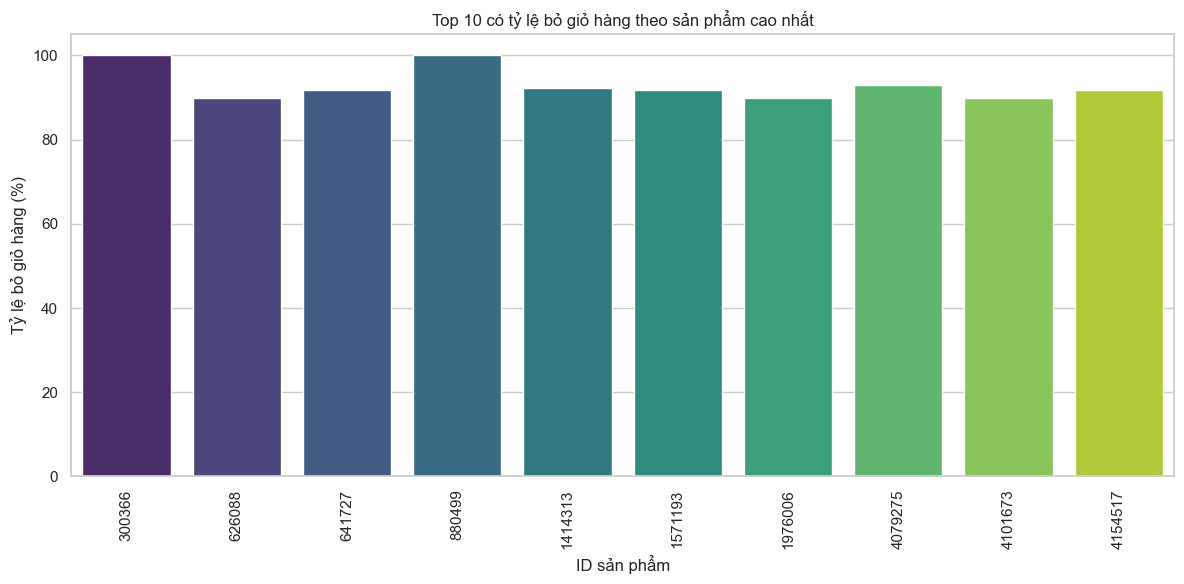

In [131]:
print(abandonment_rate_sorted.head())
top10 = abandonment_rate_sorted.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='product_id', y='abandonment_rate', data=top10, palette='viridis')
plt.title('Top 10 có tỷ lệ bỏ giỏ hàng theo sản phẩm cao nhất')
plt.xlabel('ID sản phẩm')
plt.ylabel('Tỷ lệ bỏ giỏ hàng (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Nhận xét:** 

Tỷ lệ bỏ giỏ hàng cực kỳ cao: Một số sản phẩm có tỷ lệ bỏ giỏ hàng lên tới 100% (ví dụ: sản phẩm có ID 300366), nghĩa là mọi khách hàng cho sản phẩm vào giỏ đều không hoàn tất đơn hàng. Đây là dấu hiệu nghiêm trọng, cần được kiểm tra lại thông tin, giá cả hoặc tình trạng tồn kho.

Nhóm sản phẩm có tỷ lệ bỏ giỏ hàng > 90% chiếm đa số: Trong top 10, hầu hết sản phẩm đều có tỷ lệ bỏ giỏ hàng trên 90%, điều này cho thấy đây là vấn đề phổ biến đối với một số loại sản phẩm cụ thể.

## 4. Phân tích sâu theo danh mục và thương hiệu


#### 4.1 Thông tin danh mục cho sản phẩm


In [132]:
product_info = df[['product_id', 'category_code', 'brand']].drop_duplicates()
abandonment_with_info = abandonment_rate_sorted.merge(product_info, on='product_id', how='left')
print(abandonment_with_info.head())


   product_id  abandoned  total_cart  abandonment_rate  \
0      300366         10          10        100.000000   
1      880499         11          11        100.000000   
2     4079275         13          14         92.857143   
3     1414313         12          13         92.307692   
4      641727         11          12         91.666667   

                       category_code     brand  
0                            unknown     bosch  
1  computers.components.power_supply    cougar  
2           computers.components.cpu       amd  
3        computers.components.cooler  pccooler  
4                            unknown      sony  


#### 4.2 Tính tỷ lệ từ bỏ theo danh mục sản phẩm


In [133]:
category_abandonment = abandonment_with_info.groupby('category_code')['abandonment_rate'].mean().sort_values(ascending=False).reset_index(name='abandonment_rate')
print(category_abandonment.shape)
print(category_abandonment.head())

(55, 2)
                       category_code  abandonment_rate
0  appliances.kitchen.coffee_machine         80.000000
1         construction.tools.welding         66.666667
2           appliances.kitchen.mixer         66.666667
3           computers.components.cpu         65.274134
4        computers.components.cooler         65.135998


#### 4.3 Trực quan hóa kết quả

C:\Users\quoch\AppData\Local\Temp\ipykernel_17032\1868417069.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category_code', y='abandonment_rate', data=top10, palette='viridis')


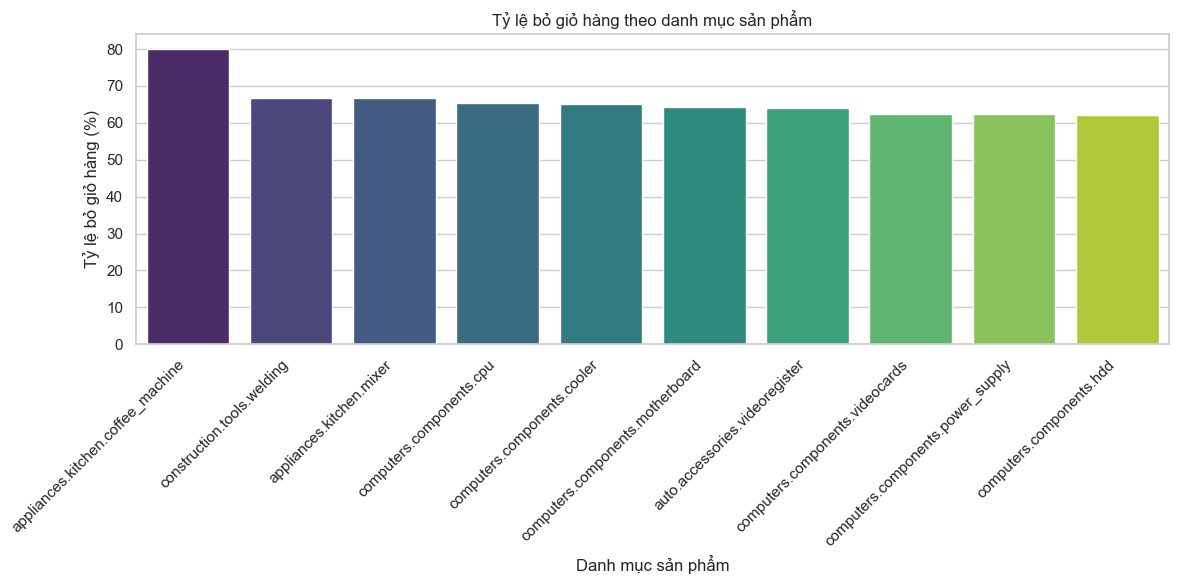

In [134]:
top10 = category_abandonment.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='category_code', y='abandonment_rate', data=top10, palette='viridis')
plt.title('Tỷ lệ bỏ giỏ hàng theo danh mục sản phẩm')
plt.xlabel('Danh mục sản phẩm')
plt.ylabel('Tỷ lệ bỏ giỏ hàng (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Nhận xét**: 

Danh mục có tỷ lệ bỏ giỏ hàng cao nhất là appliances.kitchen.coffee_machine với tỷ lệ gần 80%, vượt trội so với các nhóm khác. Điều này đặt ra nghi vấn về:

Giá cả sản phẩm có quá cao? \
Hình ảnh, mô tả chưa đủ hấp dẫn? \
Có thiếu thông tin sản phẩm hoặc đánh giá người dùng?\
Các danh mục thuộc nhóm "máy tính và linh kiện" chiếm đa số trong top 10: \
computers.components.cpu, motherboard, cooler, hdd, videocards.. \
Điều này cho thấy nhóm sản phẩm công nghệ có thể đang gặp vấn đề chung — có thể là do mức độ cạnh tranh cao, khách hàng so sánh nhiều hoặc do khó hiểu thông số kỹ thuật. \
Mức chênh lệch giữa các danh mục trong top 10 không quá lớn (~65–80%) \

## 5. Phân tích theo thời gian 

#### 5.1 Thống kê theo giờ trong ngày


In [135]:
#Chuyển đổi kiểu dữ liệu time
df['event_time'] = pd.to_datetime(df['event_time'])
df['event_time'].head()

0   2020-09-24 11:57:06+00:00
1   2020-09-24 11:57:26+00:00
2   2020-09-24 11:57:27+00:00
3   2020-09-24 11:57:33+00:00
4   2020-09-24 11:57:36+00:00
Name: event_time, dtype: datetime64[ns, UTC]

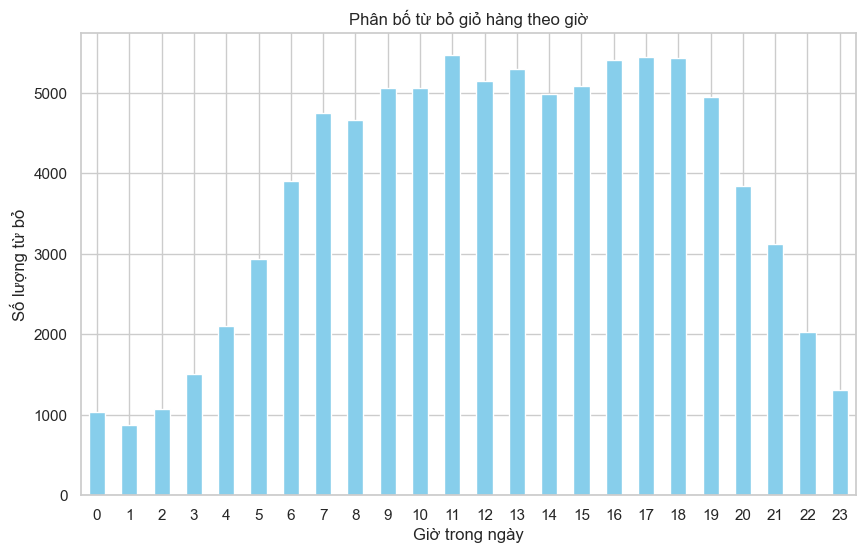

In [136]:
df['hour'] = df['event_time'].dt.hour
abandoned_sessions_data = df[df['user_session'].isin(abandoned_sessions)]

plt.figure(figsize=(10, 6))
abandoned_sessions_data['hour'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Số lượng từ bỏ')
plt.xticks(rotation=0, ha='center')

plt.title('Phân bố từ bỏ giỏ hàng theo giờ')
plt.show()

**Nhận xét**

Thời điểm cao nhất về từ bỏ giỏ hàng:
- Từ 9h sáng đến 18h là khoảng thời gian có số lượt từ bỏ giỏ hàng cao nhất, đặc biệt là vào 11h và 17h, đạt đỉnh hơn 5.500 lượt.
- Điều này trùng với giờ hành chính, có thể do người dùng truy cập trong giờ nghỉ/nghỉ trưa nhưng không hoàn tất giao dịch vì bận công việc trở lại.

Tỷ lệ từ bỏ thấp vào ban đêm:
- Từ 0h đến 5h sáng, lượng từ bỏ rất thấp (< 2000), do số lượng người mua hàng ít hơn trong thời gian này.
- Đây là thời gian ít hoạt động, nên có thể được xem là "thời gian yên tĩnh" trong hành vi người dùng.
- Dạng phân bố có hình dạng giống "đỉnh chuông lệch phải", thể hiện xu hướng tăng vào sáng–trưa và giảm dần từ chiều–tối.

## 6. Tổng kết


**1. Thông qua việc phân tích dữ liệu và trực quan hoá từ các biểu đồ  chỉ ra những điểm chính sau:**

- Tỷ lệ từ bỏ giỏ hàng theo sản phẩm (product_id):
- Nhiều sản phẩm có tỷ lệ bỏ giỏ lên tới 100%, cho thấy có những mặt hàng không hấp dẫn hoặc có vấn đề trong trải nghiệm mua sắm (mô tả, giá, hình ảnh...).
- Những sản phẩm nằm trong top này cần được ưu tiên xem xét để điều chỉnh hoặc loại bỏ khỏi danh mục nếu không phù hợp.

**2. Tỷ lệ từ bỏ theo danh mục sản phẩm (category_code):**

- Các danh mục như appliances.kitchen.coffee_machine và nhiều sản phẩm công nghệ (CPU, GPU, PSU...) có tỷ lệ bỏ giỏ cao.
- Điều này gợi ý rằng các mặt hàng giá trị cao hoặc mang tính kỹ thuật dễ bị từ bỏ hơn — người dùng có thể muốn cân nhắc thêm hoặc so sánh trước khi mua.

**3. Phân bố theo thời gian trong ngày:**

- Người dùng thường từ bỏ giỏ hàng nhiều nhất từ 9h sáng đến 18h, với đỉnh điểm vào khoảng 11h và 17h.
- Đây là khung thời gian quan trọng để thực hiện các biện pháp nhắc nhở mua hàng, tối ưu hóa trải nghiệm hoặc tung ra chương trình giảm giá.

**Đề xuất:**

- Tối ưu hoá sản phẩm có tỷ lệ bỏ giỏ cao: kiểm tra lại nội dung mô tả, giá cả, hình ảnh, chính sách giao hàng.
- Tăng cường retargeting: gửi email/tin nhắn nhắc nhở vào các khung giờ cao điểm từ bỏ.
- Đơn giản hoá trải nghiệm thanh toán: đảm bảo quy trình mua hàng mượt mà, không gián đoạn hoặc phức tạp.
- Xem xét lại danh mục có vấn đề: điều chỉnh danh mục sản phẩm hoặc cân nhắc thay đổi chiến lược tiếp thị với nhóm hàng bị từ bỏ nhiều.